In [ ]:
%pip install OSMPythonTools

In [ ]:
%pip install shapely

In [136]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt

import requests
import json
from shapely.geometry import shape
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union

from OSMPythonTools.api import Api
from OSMPythonTools.overpass import Overpass
from OSMPythonTools.nominatim import Nominatim

# import random
# from shapely.geometry import Point, LineString
# from shapely.ops import unary_union
# from shapely import offset_curve
# from dotenv import load_dotenv
# import requests

%matplotlib inline
pd.set_option('display.max_columns', None)  # Show all columns

In [88]:
def fetch_osm_features(area_name, tags, element_types=('way', 'relation')):
    """
    Query Overpass API for given tag-value pairs within a named area.
    Args:
        tags (dict): Dictionary of tag-value pairs to query.
        area_name (str): OSM area name to search within.
        element_types (tuple): Tuple of element types to fetch (e.g., ('way', 'relation')).  
    Returns:
        gpd.GeoDataFrame: GeoDataFrame of geometries with attributes.
    """
    
    overpass_url = "https://overpass-api.de/api/interpreter"

    # Build Overpass tag filter for specified element types
    tag_filters = "\n".join(
        f'  {etype}["{k}"="{v}"](area.searchArea);'
        for etype in element_types
        for k, v in tags.items()
    )

    # Build full query
    overpass_query = f"""
    [out:json][timeout:300];
    area["name"="{area_name}"]->.searchArea;
    (
    {tag_filters}
    );
    out body;
    >;
    out skel qt;
    """

    # Query Overpass API
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()

    # Split OSM elements by type
    nodes = {}
    ways = []
    relations = []

    for el in data['elements']:
        if el['type'] == 'node':
            nodes[el['id']] = (el['lon'], el['lat'])
        elif el['type'] == 'way':
            ways.append(el)
        elif el['type'] == 'relation':
            relations.append(el)

     # Build geometries from ways
    features = []
    if 'way' in element_types:
        for way in ways:
            try:
                coords = [nodes[nid] for nid in way['nodes'] if nid in nodes]
                
                if len(coords) > 0:  # Make sure we have valid coordinates
                    if coords[0] == coords[-1]:  # Closed polygon
                        geometry = Polygon(coords)
                    else:  # LineString if not closed
                        geometry = LineString(coords)
                    features.append({
                        'id': way['id'],
                        'tags': way.get('tags', {}),
                        'geometry': geometry
                    })
            except KeyError:
                continue  # Incomplete geometry, skip

    # Handle relations if needed
    if 'relation' in element_types:
        for relation in relations:
            try:
                coords = []
                for member in relation['members']:
                    if member['type'] == 'way' and member['ref'] in ways:
                        # Fetch way and add its coordinates
                        way = next(w for w in ways if w['id'] == member['ref'])
                        way_coords = [nodes[nid] for nid in way['nodes'] if nid in nodes]
                        
                        if way_coords:  # Only add coordinates if they are valid
                            coords.extend(way_coords)

                if len(coords) > 0:  # Ensure coords is not empty
                    if coords[0] == coords[-1]:  # Closed polygon
                        geometry = Polygon(coords)
                    else:  # LineString if not closed
                        geometry = LineString(coords)

                    features.append({
                        'id': relation['id'],
                        'tags': relation.get('tags', {}),
                        'geometry': geometry
                    })
            except KeyError:
                continue  # Skip incomplete relations


    # Build GeoDataFrame
    gdf = gpd.GeoDataFrame(features, geometry='geometry', crs='EPSG:4326')
    gdf = gdf.to_crs(epsg=27700)

    # Convert Linestrings to Polygons
    def close_and_convert(ls):
        if ls.coords[0] != ls.coords[-1]:
            coords = list(ls.coords)
            coords.append(coords[0])  # Force close
            return Polygon(coords)
        return Polygon(ls.coords)

    # Apply only to LineStrings
    gdf['geometry'] = gdf['geometry'].apply(
        lambda geom: close_and_convert(geom) if isinstance(geom, LineString) else geom
    )

    # Flatten tags into columns
    if not gdf.empty:
        tags_df = pd.json_normalize(gdf['tags'])
        gdf = pd.concat([gdf.drop(columns='tags'), tags_df], axis=1)

    return gdf

        id                                           geometry leisure  \
0  2838058  POLYGON ((532166.114 197855.748, 532067.797 19...    park   
1  2903046  POLYGON ((533048.812 198168.52, 533047.346 198...    park   
2  2903368  POLYGON ((532439.439 197659.703, 532438.091 19...    park   
3  2903369  POLYGON ((532707.357 197545.844, 532728.192 19...    park   
4  2903398  POLYGON ((533687.258 196156.89, 533685.533 196...    park   

                 name name:alt website wikidata wikipedia opening_hours  \
0                 NaN      NaN     NaN      NaN       NaN           NaN   
1                 NaN      NaN     NaN      NaN       NaN           NaN   
2  St Michael's Green      NaN     NaN      NaN       NaN           NaN   
3                 NaN      NaN     NaN      NaN       NaN           NaN   
4      Bush Hill Park      NaN     NaN      NaN       NaN           NaN   

  alt_name  ... size source:date source:size prow_ref source:prow_ref  \
0      NaN  ...  NaN         NaN     

<Axes: >

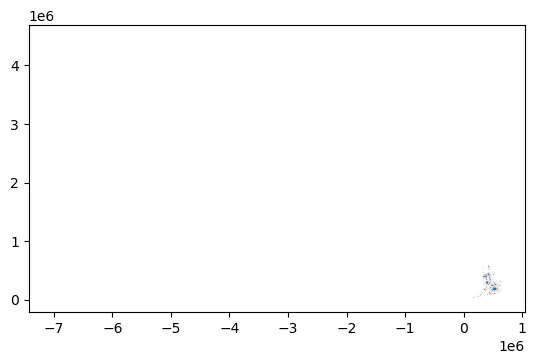

In [101]:
tags = {"leisure": "park", "access": "public"}
gdf = fetch_osm_features("England", tags, element_types=("way", "relation"))

print(gdf.head())
print(f"Total features: {len(gdf)}")

# Save or plot
# gdf.to_file("filtered_features.geojson", driver="GeoJSON")
gdf.plot()

In [106]:
print(gdf.geometry.type.value_counts())

Polygon    30828
Name: count, dtype: int64


In [115]:
gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [ ]:
# Calculate area in square meters
gdf['area_m2'] = gdf['geometry'].area

# Set a minimum area threshold (e.g. 10,000 m² = 1 hectare)
min_area_m2 = 1_000_000

# Filter by area
gdf_filtered = gdf[gdf['area_m2'] >= min_area_m2]

# Show some results
print(gdf_filtered.head())
print(f"Filtered parks (> {min_area_m2:,} m²): {len(gdf_filtered)}")

          id                                           geometry leisure  \
92   3907312  POLYGON ((452194.882 310967.918, 452197.062 31...    park   
93   3907315  POLYGON ((449922.161 318563.879, 449870.678 31...    park   
98   3986346  POLYGON ((526780.338 179732.945, 526780.516 17...    park   
105  3991615  POLYGON ((517447.097 168798.504, 517435.636 16...    park   
136  4006015  POLYGON ((517618.307 175238.305, 517545.713 17...    park   

                   name name:alt  \
92        Bradgate Park      NaN   
93        Garendon Park      NaN   
98   Kensington Gardens      NaN   
105  Hampton Court Park      NaN   
136       Old Deer Park      NaN   

                                               website  wikidata  \
92                        https://www.bradgatepark.org  Q4954802   
93                                                 NaN       NaN   
98   https://www.royalparks.org.uk/visit/parks/kens...   Q822607   
105                                                NaN  Q290

<Axes: >

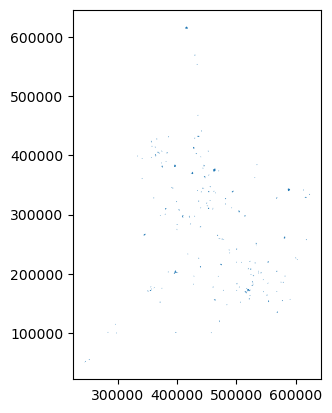

In [ ]:
gdf_filtered.plot() #this was "leisure": "park", "access": "public", size more than 100 ha

In [120]:
gdf_filtered.head(10)

,id,geometry,leisure,name,name:alt,website,wikidata,wikipedia,opening_hours,alt_name,...,source:date,source:size,prow_ref,source:prow_ref,tactile_paving,locked,suburb,kei,nat_name,area_m2
92,3907312,"POLYGON ((452194.882 310967.918, 452197.062 31...",park,Bradgate Park,NaN,https://www.bradgatepark.org,Q4954802,en:Bradgate Park,NaN,Bradgate Country Park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.388855e+06
93,3907315,"POLYGON ((449922.161 318563.879, 449870.678 31...",park,Garendon Park,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.602016e+06
98,3986346,"POLYGON ((526780.338 179732.945, 526780.516 17...",park,Kensington Gardens,NaN,https://www.royalparks.org.uk/visit/parks/kens...,Q822607,en:Kensington Gardens,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.096592e+06
105,3991615,"POLYGON ((517447.097 168798.504, 517435.636 16...",park,Hampton Court Park,NaN,NaN,Q2909007,en:Hampton Court Park,NaN,Home Park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.033726e+06
136,4006015,"POLYGON ((517618.307 175238.305, 517545.713 17...",park,Old Deer Park,NaN,NaN,Q7083838,en:Old Deer Park,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.358903e+06
280,4257697,"POLYGON ((546227.776 190435.338, 546363.436 19...",park,Fairlop Waters Country Park,NaN,NaN,Q115184182,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.117686e+06
489,4426457,"POLYGON ((602348.587 224418.658, 602337.344 22...",park,Wivenhoe Park,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.083727e+06
663,4716592,"POLYGON ((384042.851 404495.359, 384034.651 40...",park,Heaton Park,NaN,https://www.heatonpark.org.uk/,Q2081327,en:Heaton Park,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.484048e+06
873,5010076,"POLYGON ((522645.178 163452.808, 522649.059 16...",park,Nonsuch Park,NaN,NaN,Q7049614,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.284743e+06
1442,16478993,"POLYGON ((453265.449 337860.575, 453260.783 33...",park,University of Nottingham,NaN,https://www.nottingham.ac.uk/,Q472316,en:University of Nottingham,NaN,University Park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.175779e+06


        id                                           geometry leaf_cycle  \
0  3322449  POLYGON ((516731.609 175456.002, 516731.84 175...      mixed   
1  3554658  POLYGON ((489037.465 307966.005, 489069.142 30...        NaN   
2  3554659  POLYGON ((488643.212 307665.192, 488645.516 30...        NaN   
3  3753332  POLYGON ((548172.184 256571.258, 548182.42 256...        NaN   
4  4001102  POLYGON ((525273.878 189085.212, 525396.391 18...  deciduous   

  leaf_type         leisure                name natural  \
0     mixed  nature_reserve       Isleworth Ait    wood   
1       NaN  nature_reserve            Lagoon 3   water   
2       NaN  nature_reserve            Lagoon 2   water   
3       NaN            park  Cherry Hinton Hall     NaN   
4       NaN  nature_reserve         Little Wood     NaN   

                                       note  place       source  ... prow_ref  \
0  River Thames multipolygon relation inner  islet  PGS + Yahoo  ...      NaN   
1                         

<Axes: >

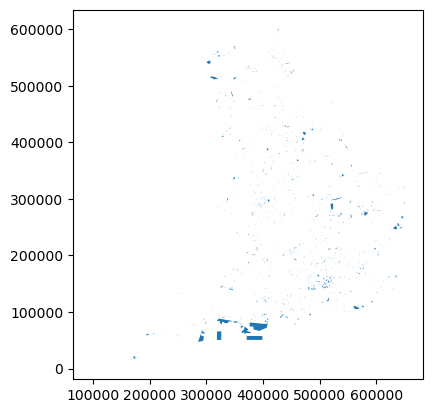

In [123]:
tags = {"leisure": "nature_reserve", "access": "public"}
gdf_nature_reserves = fetch_osm_features("England", tags, element_types=("way", "relation"))

print(gdf_nature_reserves.head())
print(f"Total features: {len(gdf_nature_reserves)}")

# Save or plot
# gdf.to_file("filtered_features.geojson", driver="GeoJSON")
gdf_nature_reserves.plot()

In [124]:
# Calculate area in square meters
gdf_nature_reserves['area_m2'] = gdf_nature_reserves['geometry'].area

# Set a minimum area threshold (e.g. 10,000 m² = 1 hectare)
min_area_m2 = 1_000_000

# Filter by area
gdf_nature_reserves_filtered = gdf_nature_reserves[gdf_nature_reserves['area_m2'] >= min_area_m2]

# Show some results
print(gdf_nature_reserves_filtered.head())
print(f"Filtered parks (> {min_area_m2:,} m²): {len(gdf_nature_reserves_filtered)}")

          id                                           geometry leaf_cycle  \
13   4306209  POLYGON ((555527.77 269131.36, 555397.047 2691...        NaN   
14   4374117  POLYGON ((519893.049 210223.172, 519892.131 21...        NaN   
33   5012857  POLYGON ((399660.438 465272.548, 399684.371 46...        NaN   
40   7939326  POLYGON ((511403.065 191923.661, 511520.327 19...        NaN   
46  11651113  POLYGON ((483458.959 423825.696, 483517.029 42...        NaN   

   leaf_type         leisure                              name  natural note  \
13       NaN  nature_reserve                        Wicken Fen      NaN  NaN   
14       NaN  nature_reserve            Symondshyde Great Wood      NaN  NaN   
33       NaN  nature_reserve                        Grass Wood      NaN  NaN   
40       NaN  nature_reserve  Oxhey Woods Local Nature Reserve     wood  NaN   
46       NaN  nature_reserve              RSPB Blacktoft Sands  wetland  NaN   

   place                                      sour

<Axes: >

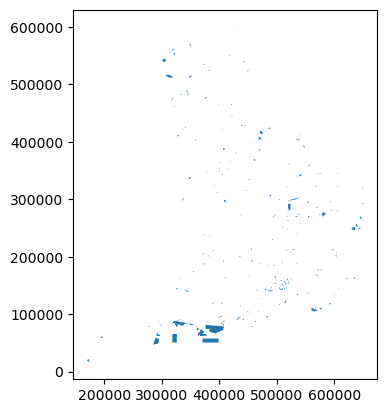

In [125]:
gdf_nature_reserves_filtered.plot() #this was "leisure": "nature_reserve", "access": "public", size more than 100 ha

        id                                           geometry leisure  access  \
0  3626437  POLYGON ((514951.538 207458.157, 514966.791 20...  garden     NaN   
1  3678121  POLYGON ((523104.34 174440.581, 523078.488 174...  garden     NaN   
2  3753332  POLYGON ((548172.184 256571.258, 548182.42 256...    park  public   
3  3787238  POLYGON ((522847.292 177411.523, 522845.254 17...  garden     NaN   
4  3842385  POLYGON ((515096.73 207459.27, 515045.093 2074...  garden     NaN   

  barrier      dog                name opening_hours  wikidata created_by  \
0     NaN      NaN                 NaN           NaN       NaN        NaN   
1     NaN      NaN                 NaN           NaN       NaN        NaN   
2   fence  leashed  Cherry Hinton Hall          24/7  Q5092398        NaN   
3     NaN      NaN                 NaN           NaN       NaN        NaN   
4     NaN      NaN                 NaN           NaN       NaN       JOSM   

   ... source:prow_ref tactile_paving private oper

<Axes: >

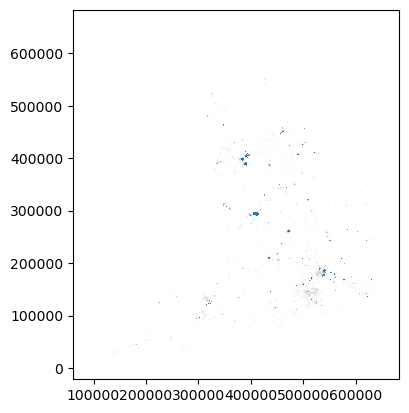

In [126]:
tags = {
  "leisure": "garden",
  "access": "public"
}

gdf_gardens = fetch_osm_features("England", tags, element_types=("way", "relation"))

print(gdf_gardens.head())
print(f"Total features: {len(gdf_gardens)}")

# Save or plot
# gdf.to_file("filtered_features.geojson", driver="GeoJSON")
gdf_gardens.plot()

              id                                           geometry leisure  \
561     41173416  POLYGON ((385797.091 190508.164, 385795.977 19...  garden   
918     85535088  POLYGON ((442003.413 101175.161, 441955.913 10...  garden   
46697  254469609  POLYGON ((378153.124 134303.438, 378153.2 1342...  garden   
59991  672923268  POLYGON ((514377.607 298765.311, 514392.86 298...  garden   
88107  964572116  POLYGON ((486211.612 112799.214, 486270.047 11...  garden   

          access barrier      dog                  name      opening_hours  \
561    customers     NaN  leashed  Westonbirt Arboretum  Mo-Su 09:00-17:00   
918    customers     NaN      NaN        Exbury Gardens                NaN   
46697        NaN     NaN      NaN        Stourhead Park                NaN   
59991    private     NaN      NaN           Milton Park                NaN   
88107  customers     NaN      NaN     West Dean Gardens                NaN   

       wikidata created_by  ... tactile_paving private o

<Axes: >

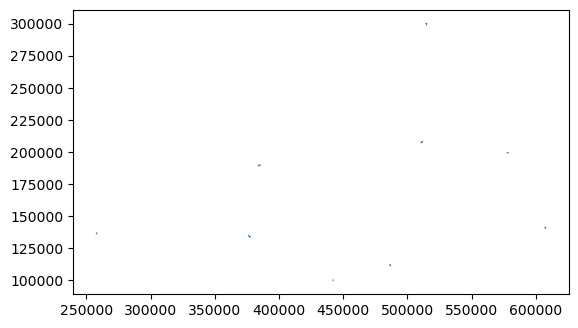

In [127]:
# Calculate area in square meters
gdf_gardens['area_m2'] = gdf_gardens['geometry'].area

# Set a minimum area threshold (e.g. 10,000 m² = 1 hectare)
min_area_m2 = 1_000_000

# Filter by area
gdf_gardens_filtered = gdf_gardens[gdf_gardens['area_m2'] >= min_area_m2]

# Show some results
print(gdf_gardens_filtered.head())
print(f"Filtered parks (> {min_area_m2:,} m²): {len(gdf_gardens_filtered)}")
gdf_gardens_filtered.plot()

In [129]:
gdf_gardens_filtered.head()

,id,geometry,leisure,access,barrier,dog,name,opening_hours,wikidata,created_by,...,tactile_paving,private,operator:url,construction,pub_garden,ref:planning:lldc,ref:manorparkcemetary150anniversaryhistoryroute,source:location,reg_name,area_m2
561,41173416,"POLYGON ((385797.091 190508.164, 385795.977 19...",garden,customers,NaN,leashed,Westonbirt Arboretum,Mo-Su 09:00-17:00,Q1636774,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.416313e+06
918,85535088,"POLYGON ((442003.413 101175.161, 441955.913 10...",garden,customers,NaN,NaN,Exbury Gardens,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.016384e+06
46697,254469609,"POLYGON ((378153.124 134303.438, 378153.2 1342...",garden,NaN,NaN,NaN,Stourhead Park,NaN,Q301338,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.710701e+06
59991,672923268,"POLYGON ((514377.607 298765.311, 514392.86 298...",garden,private,NaN,NaN,Milton Park,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.019956e+06
88107,964572116,"POLYGON ((486211.612 112799.214, 486270.047 11...",garden,customers,NaN,NaN,West Dean Gardens,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.736107e+06


In [ ]:
# print(gdf_national_parks.geometry.type.value_counts())

Polygon    5406
Name: count, dtype: int64


        id                                           geometry bicycle  \
0  2763163  POLYGON ((354091.823 358709.182, 354082.405 35...     yes   
1  3753332  POLYGON ((548172.184 256571.258, 548182.42 256...     NaN   
2  4008229  POLYGON ((547248.005 260729.808, 547233.705 26...     NaN   
3  4018087  POLYGON ((460427.048 256510.136, 460431.924 25...     NaN   
4  4306209  POLYGON ((555527.77 269131.36, 555397.047 2691...     NaN   

         boundary foot       highway horse lanes motorcar  \
0  protected_area  yes  unclassified   yes     2      yes   
1             NaN  NaN           NaN   NaN   NaN      NaN   
2  protected_area  NaN           NaN   NaN   NaN      NaN   
3  protected_area  NaN           NaN   NaN   NaN      NaN   
4  protected_area  NaN           NaN   NaN   NaN      NaN   

                                 name  ... disused:landuse protected  \
0                     Bates Mill Lane  ...             NaN       NaN   
1                  Cherry Hinton Hall  ...        

<Axes: >

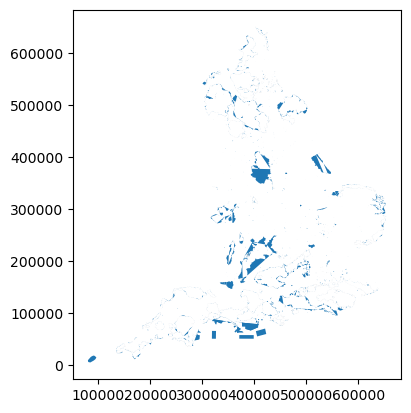

In [130]:
tags = {
  "boundary": "protected_area"
  # "access": "public"
}

gdf_protected_areas = fetch_osm_features("England", tags, element_types=("way", "relation"))

print(gdf_protected_areas.head())
print(f"Total features: {len(gdf_protected_areas)}")

# Save or plot
# gdf.to_file("filtered_features.geojson", driver="GeoJSON")
gdf_protected_areas.plot()

          id                                           geometry bicycle  \
4    4306209  POLYGON ((555527.77 269131.36, 555397.047 2691...     NaN   
16  24210654  POLYGON ((533033.282 250053.58, 533514.579 250...     NaN   
31  29432331  POLYGON ((459907.271 367085.124, 460751.875 36...     NaN   
37  31317836  POLYGON ((393667.434 439382.551, 393471.445 43...     NaN   
57  43173644  POLYGON ((387804.406 118299.725, 387629.595 11...     NaN   

          boundary        foot highway horse lanes motorcar  \
4   protected_area         NaN     NaN   NaN   NaN      NaN   
16  protected_area         NaN     NaN   NaN   NaN      NaN   
31  protected_area         NaN     NaN   NaN   NaN      NaN   
37  protected_area         NaN     NaN   NaN   NaN      NaN   
57  protected_area  designated     NaN   NaN   NaN      NaN   

                              name  ... protected tactile_paving locked  \
4                       Wicken Fen  ...       NaN            NaN    NaN   
16                  

<Axes: >

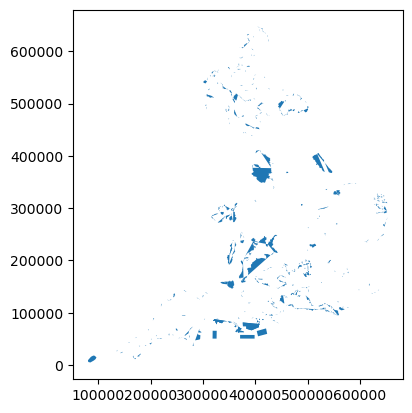

In [131]:
gdf_protected_areas['area_m2'] = gdf_protected_areas['geometry'].area

# Set a minimum area threshold (e.g. 10,000 m² = 1 hectare)
min_area_m2 = 1_000_000

# Filter by area
gdf_protected_areas_filtered = gdf_protected_areas[gdf_protected_areas['area_m2'] >= min_area_m2]

# Show some results
print(gdf_protected_areas_filtered.head())
print(f"Filtered parks (> {min_area_m2:,} m²): {len(gdf_protected_areas_filtered)}")
gdf_protected_areas_filtered.plot()

In [137]:
gdf_protected_areas_filtered.head()

,id,geometry,bicycle,boundary,foot,highway,horse,lanes,motorcar,name,surface,access,barrier,dog,leisure,opening_hours,wikidata,wikipedia,leaf_cycle,leaf_type,natural,protect_class,source,website,designation,operator,operator:type,operator:wikidata,tourism,archaeological_site,embankment,fortification_type,historic,historic:civilization,note,amenity,alt_name,communication:amateur_radio:pota,source:name,description,layer,salt,tidal,wetland,landcover,protection_title,url,incline,motor_vehicle,width,FIXME,fixme,loc_name,old_name,landuse,fee,capacity,parking,contact:website,ref:GB:uprn,url:bexhillnature,wikimedia_commons,wikimedia_commons:pano,name:is,short_name,short_name:cs,contact:email,contact:facebook,ref:charity,start_date,wikimedia_commons:1,wikimedia_commons:2,addr:housename,addr:postcode,addr:street,fixme:designation,source:designation,note:name,civilization,historic:era,historic:period,megalith_type,place,wheelchair,check_date,oneway,conservation_organization,managed,ownership,indoor,source:protection_title,protect_id,area,plant_community,Fixme,fence_type,capacity:disabled,covered,maxstay,ref,access_land,flood_prone,meadow,owner,species,official_name,email,phone,name:signed,grassland,military,name:es,name:fr,name:ja,name:pt,name:ru,type,access:conditional,supervised,Lowland,protection_title2,governance_type,addr:city,protection_aim,valid_from,historic:operator,operator:short,name:la,building,park_ride,ruins,heritage,man_made,drinking_water,toilets:disposal,toilets:position,protected_area,material,residential,denomination,heritage:operator,heritage:website,image,name:zh,ref:whc,whc:criteria,ele,whc:inscription_date,whc:name,whc:website,changing_table,female,male,portable,toilets:handwashing,was:amenity,source:geometry,boundary_1,waterway,lit,source:description,storage,top_soil,plant,protection_object,abandoned:landuse,resource,listed_status,service,water,basin,addr:suburb,note:landuse,period,source:outline,handrail,ramp,stroller,geological,animal,animal_shelter,animal_shelter:release,animal_shelter:sanctuary,prow_ref,source:prow_ref,disused:landuse,protected,tactile_paving,locked,alt_website,park,seasonal,taxon,inscription,reg_name,area_m2
4,4306209,"POLYGON ((555527.77 269131.36, 555397.047 2691...",NaN,protected_area,NaN,NaN,NaN,NaN,NaN,Wicken Fen,NaN,NaN,NaN,NaN,nature_reserve,NaN,Q7998320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,national_nature_reserve,National Trust,charitable,Q333515,attraction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.809594e+06
16,24210654,"POLYGON ((533033.282 250053.58, 533514.579 250...",NaN,protected_area,NaN,NaN,NaN,NaN,NaN,Wimpole Estate,NaN,NaN,NaN,NaN,park,NaN,Q68990657,en:Wimpole Estate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,National Trust,charitable,Q333515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [140]:
gdf_protected_areas_filtered["designation"].value_counts()

designation
Marine Conservation Zone               8
site_of_special_scientific_interest    6
Special Area of Conservation           3
national_nature_reserve                2
access_land                            2
Braunton Burrows                       1
common                                 1
Royal Park                             1
Marine Conservation zone               1
Name: count, dtype: int64

In [ ]:
# tags = {
#   "natural": "wood",
#   "access": "public"
# }

# gdf_wood = fetch_osm_features("England", tags, element_types=("way", "relation"))

# print(gdf_wood.head())
# print(f"Total features: {len(gdf_wood)}")

# # Save or plot
# # gdf.to_file("filtered_features.geojson", driver="GeoJSON")
# gdf_wood.plot()

In [ ]:
tags = {
  "type": "railwayStation"
}

stations = fetch_osm_features("England", tags, element_types=("nodes"))

print(stations.head())
print(f"Total features: {len(stations)}")

# Save or plot
# gdf.to_file("filtered_features.geojson", driver="GeoJSON")
stations.plot()